# Preliminary Data Analysis

## Objective
The following notebook aims to perform some preliminary data analysis on the last.fm dataset used at HetRec2011 which can be found [Here](https://grouplens.org/datasets/hetrec-2011/). We aim to perform the following analysis:

* **Missing Values**
    * Test for the occurence of missing values across our data
    * Understand the impact of missing values on our analysis
* **Data Distribution**
    * Is a particular genre over or under represented?
    * With respect to users-artists, what is the distribution of 'number of listens'?

As well as these defined objectives, this notebook intends to explore our data, and develop a sense for the nature of the information and how disparate data sources relate to one another.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Let's view the user-artist data first
user_artist = pd.read_csv('../data/user_artists.dat', sep='\t', encoding='latin-1')
user_artist.head()

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983


## Missing Values

In [3]:
#Test for the occurence of missing values
import os
for file in os.listdir('../data/'):
    if file != 'readme.txt':
        df = pd.read_csv(f'../data/{file}', sep='\t', encoding='latin-1')
        print(f'Reading file: {file} | Contains missing data: {df.isnull().values.any()}')

Reading file: artists.dat | Contains missing data: True
Reading file: tags.dat | Contains missing data: False
Reading file: user_artists.dat | Contains missing data: False
Reading file: user_friends.dat | Contains missing data: False
Reading file: user_taggedartists-timestamps.dat | Contains missing data: False
Reading file: user_taggedartists.dat | Contains missing data: False


In [4]:
#Investigating missing data in artists.dat
artists = pd.read_csv('../data/artists.dat', sep='\t', encoding='latin-1')
artists.shape

(17632, 4)

In [5]:
#Total number of rows in artists with missing values
artists[artists.isna().any(axis=1)].shape

(444, 4)

In [6]:
#Columns in artists with missing values
for col in artists.columns:
    print(f'Column: {col} | Contains missing data: {artists[col].isnull().values.any()}')

Column: id | Contains missing data: False
Column: name | Contains missing data: False
Column: url | Contains missing data: False
Column: pictureURL | Contains missing data: True


In [7]:
#Let's check that artist names and ID's are unique
print(artists.id.is_unique)
print(artists.name.is_unique)

True
True


### Findings
The data is very clean with $5/6$ datasets having no missing values. The artists data does contain missing values, however only in the 'pictureURL' column. This column will not be a fundamental part of any analysis. Therefore, there is no impact of missing values on our data.

---

## Data Distribution

In [8]:
# Let's investigate how different genres are represented in our data
tagged_artists = pd.read_csv('../data/user_taggedartists.dat', sep='\t', encoding='latin-1')
tags = pd.read_csv('../data/tags.dat', sep='\t', encoding='latin-1')
tagged_artists.head()

,userID,artistID,tagID,day,month,year
0,2,52,13,1,4,2009
1,2,52,15,1,4,2009
2,2,52,18,1,4,2009
3,2,52,21,1,4,2009
4,2,52,41,1,4,2009


In [19]:
#Let's count the tags that appear
tag_count = tagged_artists[['tagID', 'artistID']].groupby('tagID').count().reset_index()
tag_count.rename({'artistID':'count'}, axis=1, inplace=True)

#Find string text values
tag_text = tag_count.merge(tags, on='tagID')

#Extract top 20 tags
top_20_tags = tag_text.sort_values(by='count', ascending=False).iloc[:20]

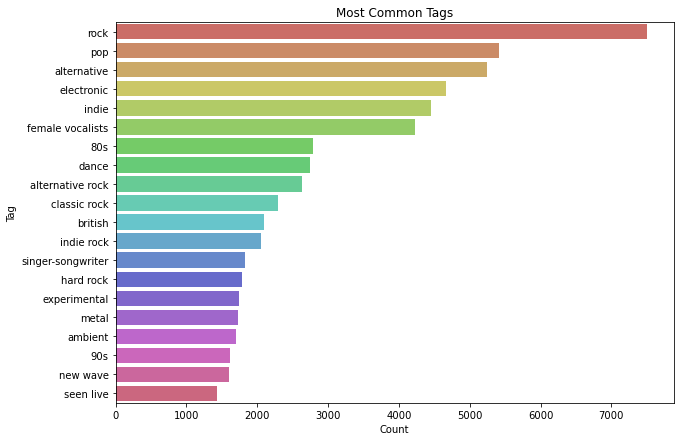

In [21]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 7))

col = sns.color_palette("hls", 20)

sns.barplot(x='count', y='tagValue', data=top_20_tags,
            label="tagValue", palette=col)

plt.title('Most Common Tags')
plt.ylabel('Tag')
plt.xlabel('Count')
plt.show()

In [22]:
#Let's investigate the distribution of number of total listens by users
listen_per_user = user_artist[['userID', 'weight']].groupby('userID').sum()

#Give each user a bin to fit in
listen_per_user['bin'] = pd.cut(listen_per_user.weight, 20, precision=2)

#Count how many users per bin
count_per_bin = listen_per_user.groupby('bin').count()

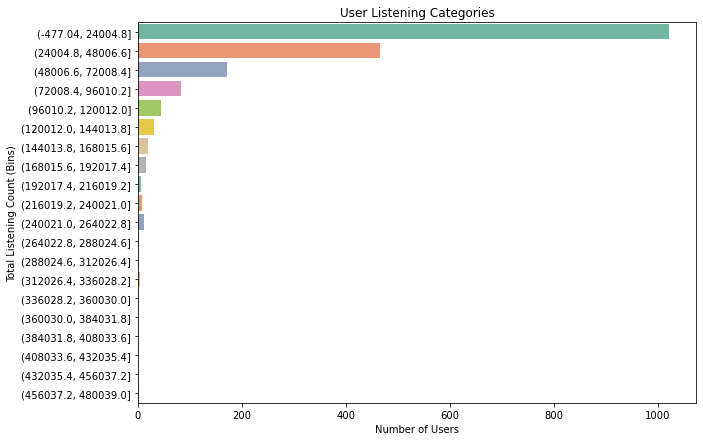

In [23]:
#Plot the bins
f, ax = plt.subplots(figsize=(10, 7))

col = sns.color_palette("Set2", 8)

sns.barplot(x='weight', y='bin', data=count_per_bin.reset_index(),
            label="bin", palette=col)

plt.title('User Listening Categories')
plt.ylabel('Total Listening Count (Bins)')
plt.xlabel('Number of Users')
plt.show()

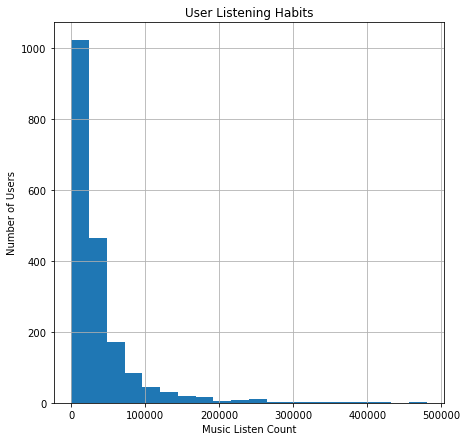

In [24]:
#Same graph but as a conventional histogram
plt.figure(figsize=(7,7))
listening_habits = user_artist[['userID', 'weight']].groupby('userID').sum()

plt.hist(listening_habits.weight, bins=20)
plt.title('User Listening Habits')
plt.xlabel('Music Listen Count')
plt.ylabel('Number of Users')
plt.grid(True)
plt.show()

In [25]:
# What portion of users are contained within the first bins
bin_1 = count_per_bin.iloc[0][0]
bin_2 = count_per_bin.iloc[1][0]
bin_3 = count_per_bin.iloc[2][0]
total_pop = len(user_artist.userID.unique())
print(f'Users in largest bin: {bin_1} | Portion of total: {(bin_1/total_pop)*100:.2f}%')
print(f'Users in second largest bin: {bin_2} | Portion of total: {(bin_2/total_pop)*100:.2f}%')
print(f'Users in third largest bin: {bin_3} | Portion of total: {(bin_3/total_pop)*100:.2f}%')

print(f'The mean of user listening habits: {listening_habits.weight.mean():.2f}')

Users in largest bin: 1022 | Portion of total: 54.02%
Users in second largest bin: 466 | Portion of total: 24.63%
Users in third largest bin: 171 | Portion of total: 9.04%
The mean of user listening habits: 36566.58


### Findings
As this dataset was used in 2011, the general music trends are those observed for that period. These musical trends differ substantially from the music we listen to today. Therefore, recommender systems build ontop of this data will produce recommendations biased towards that time period. This is not an error, rather just a property of the data.

We see that **rock** features heavily in the top 20 tags found throughout the data, arising in many forms from metal and hard, to classic and indie. In terms of users listening habits, we observe that the vaste majority of users (**54%**) have listened to songs 24,000 or less times. By the third bin, a cummulative **87%** of users have listened to music 72,000 times or less. The majority of the final bins contain extraim outliers such as users who have listened to music over 480,000 times.

I did expect user listening habits to follow more of a normal distribution, and was surprised to find the distribution follows a curve more closely related to exponential decay. The distribution is skewed to the right and decreases sharply. The mean is 36,566 listens.

## Conclusions
The usability of this data is quite high, therefore requiring only a short preliminary analysis. The data is clean and structured, featuring missing values only for unimportant features like 'pictureURL'. There are no duplicate artists featured in the data.

An analysis of the user listening habits allows us to better understand the distribution of the data we are using. Investigation of the most popular tags used to describe music in this dataset helped us understand trends which are representative of the time period in which the data was released. With this knowledge, we will better understand the output of the recommender system we are developing later on.